In [1]:
import pandas as pd   
import numpy as np
from textblob import TextBlob  
import sys            
import tweepy         
import os
import nltk
import pycountry
import re
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')
# Settings for Matplotlib graphs and charts
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nanas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nanas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nanas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
## load the data
data = pd.read_excel('data.xlsx', engine='openpyxl')
data.head()

,Date,Time,user_id,location,text
0,2021-02-11,19:03:21,b'BurtonKelso',b'Greater Kansas City Area',b'... that time I met @antoni from @QueerEye !...
1,2021-02-11,19:02:38,b'AnaraPublishing',"b'Leicester, England'",b'With platforms like #Netflix and #AmazonPrim...
2,2021-02-11,19:01:05,b'WiltsColl',"b'Wiltshire, UK'","b'This time last week, we were still buzzing f..."
3,2021-02-11,19:00:41,b'poem1985',b'United Kingdom',b'Had a gorgeous tea &amp; now gonna chill wit...
4,2021-02-11,19:00:32,b'screenkingsPH',b'Philippines',b'#NewsOfTheWorld now streaming on Netflix! (E...


## Data Preprocessing 

Before we start our sentiment analysis it is a good idea to clean up each tweets from an unnecessary data first.

We are going to create a cleanUpTweet function that will:

- remove mentions
- remove hashtags
- remove retweets
- remove urls

In [17]:
## drop the columns we don't really need
#df = data.drop(columns=['Date', 'Time', 'user_id', 'location'])
#df.head

<bound method NDFrame.head of                                                    text
0     b'... that time I met @antoni from @QueerEye !...
1     b'With platforms like #Netflix and #AmazonPrim...
2     b'This time last week, we were still buzzing f...
3     b'Had a gorgeous tea &amp; now gonna chill wit...
4     b'#NewsOfTheWorld now streaming on Netflix! (E...
...                                                 ...
3994  b'Watch  In HD now!!\nfollow the link and enjo...
3995  b'\xe2\x80\x98Behind Her Eyes\xe2\x80\x99 Netf...
3996  b'Everyone is ways talking about the friends s...
3997  b'Who\xe2\x80\x99s watched the superb #CallMyA...
3998  b'Netflix \xc2\xa311.99 to \xc2\xa313.99 \xf0\...

[3999 rows x 1 columns]>

In [3]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
#data = pd.DataFrame(data)
#data["text"] = data

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
data["text"] = data.text.map(remove_rt).map(rt)
data["text"] = data.text.str.lower()


In [4]:
# Tokenization
def tokenize(text):
    text = re.split('\W+', text)
    return text

clean_token = data.text.apply(lambda x: tokenize(x.lower()))
clean_token.head()

# https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis

0    [b, that, time, i, met, from, he, didn, xe2, x...
1    [b, with, platforms, like, netflix, and, amazo...
2    [b, this, time, last, week, we, were, still, b...
3    [b, had, a, gorgeous, tea, amp, now, gonna, ch...
4    [b, newsoftheworld, now, streaming, on, netfli...
Name: text, dtype: object

In [5]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
stopword = stopwords.words('english')
more_stopwords = ["u", "im", "c", "amp", "quot", "r", "I", "b"
                  "The", "day", "today", "go", "k", "Us", "us", ""]
stop_words = stopword + more_stopwords

def stopwords_removal(text):
    text = [word for word in text if word not in stop_words]
    return text

tweets_nostop = clean_token.apply(lambda x: stopwords_removal(x))
tweets_nostop.head()

0    [b, time, met, xe2, x80, x99t, think, needed, ...
1    [b, platforms, like, netflix, amazonprime, nev...
2    [b, time, last, week, still, buzzing, fantasti...
3    [b, gorgeous, tea, gonna, chill, babes, watchi...
4    [b, newsoftheworld, streaming, netflix, except...
Name: text, dtype: object

In [7]:
tweets_no_sw = tweets_nostop.apply(lambda x: ' '.join([item for item in x if len(item)>2]))

lemmatizer = WordNetLemmatizer()
lemmatize_tokens = tweets_no_sw.apply(lemmatizer.lemmatize)

lemmatize_tokens


0       time met xe2 x80 x99t think needed make tbthur...
1       platforms like netflix amazonprime never oppor...
2       time last week still buzzing fantastic webinar...
3         gorgeous tea gonna chill babes watching netflix
4       newsoftheworld streaming netflix except canada...
                              ...                        
3994                     watch nfollow link enjoy netflix
3995    xe2 x80 x98behind eyes xe2 x80 x99 netflix rel...
3996    everyone ways talking friends series love btw ...
3997      xe2 x80 x99s watched superb callmyagent netflix
3998    netflix xc2 xa311 xc2 xa313 xf0 x9f x98 x8f nm...
Name: text, Length: 3999, dtype: object

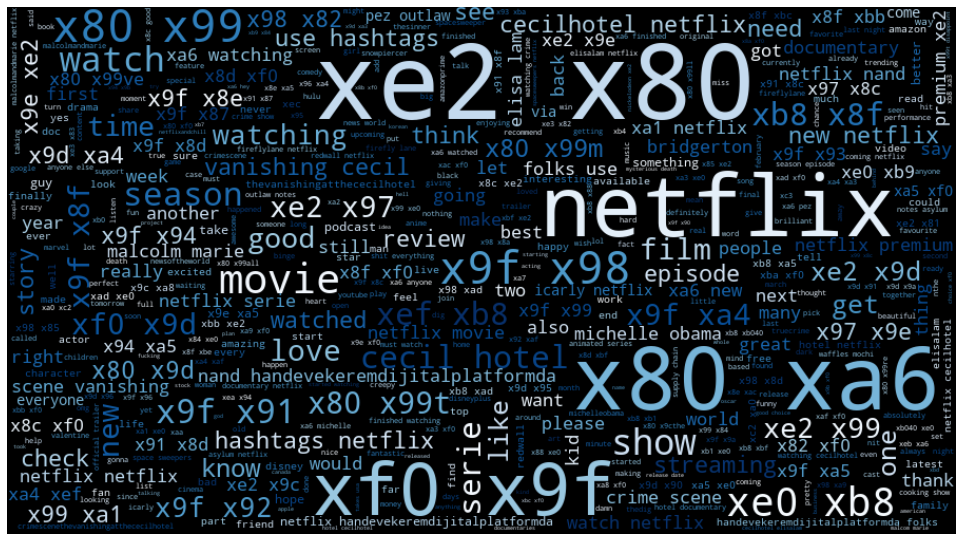

In [8]:
# Word cloud 
tweets = ' '.join([word for word in lemmatize_tokens])

WC = WordCloud(width = 900,
               height = 500,
               stopwords = set(stop_words),
               max_words = 500,
               max_font_size = 100,
               relative_scaling = 0.5,
               colormap = "Blues",
               random_state=1).generate(tweets)

fig = plt.figure(1, figsize=(17,14))
plt.axis('off')
fig.subplots_adjust(top=2.3)
plt.imshow(WC, interpolation = "bilinear")
plt.show()

# https://www.kirenz.com/post/2021-12-11-text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/

## Calculate the Sentiment score using TextBlob

In [16]:
data.drop_duplicates(inplace = True)

Extracting text values
text_all = tweet_list[0].values text_neutral = neutral_list[0].values text_positive = positive_list[0].values text_negative = negative_list[0].values

In [15]:
import nltk
nltk.download('vader_lexicon')

#Calculating Negative, Positive, Neutral and Compound values


data[['polarity', 'subjectivity']] = lemmatize_tokens.apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in data['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        data.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        data.loc[index, 'sentiment'] = "positive"
    else:
        data.loc[index, 'sentiment'] = "neutral"
    data.loc[index, 'neg'] = neg
    data.loc[index, 'neu'] = neu
    data.loc[index, 'pos'] = pos
    data.loc[index, 'compound'] = comp

data.head()

# https://medium.com/@andrew.schleiss/twitter-sentiment-analysis-with-twint-and-textblob-53edbb133bbd#:~:text=Sentiment%20Analysis%20(Textblob)&text=Passing%20each%20tweet%20string%20through,Positive%2C%20depending%20on%20the%20polarity

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nanas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Date,Time,user_id,location,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,2021-02-11,19:03:21,b'BurtonKelso',b'Greater Kansas City Area',b that time i met from he didn xe2 x...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,2021-02-11,19:02:38,b'AnaraPublishing',"b'Leicester, England'",b with platforms like netflix and amazonprim...,0.000000,0.125000,positive,0.105,0.786,0.109,0.0256
2,2021-02-11,19:01:05,b'WiltsColl',"b'Wiltshire, UK'",b this time last week we were still buzzing f...,0.200000,0.483333,positive,0.000,0.854,0.146,0.5574
3,2021-02-11,19:00:41,b'poem1985',b'United Kingdom',b had a gorgeous tea amp now gonna chill wit...,0.700000,0.900000,positive,0.000,0.733,0.267,0.6124
4,2021-02-11,19:00:32,b'screenkingsPH',b'Philippines',b newsoftheworld now streaming on netflix e...,-0.500000,1.000000,negative,0.218,0.782,0.000,-0.6486
5,2021-02-11,19:00:11,b'easons',b'Ireland',b it s dropping on netflix tomorrow xe2 x99 ...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
6,2021-02-11,19:00:00,b'StreamingWar',b'Midwest USA',b new trailer pacific rim the black on netfl...,-0.015152,0.443939,neutral,0.000,1.000,0.000,0.0000
7,2021-02-11,18:59:13,b'thenerdstash',b'Nerds Incorporated',b iron fist finn jones reveals plot details f...,0.000000,0.000000,positive,0.000,0.797,0.203,0.4215
8,2021-02-11,18:57:59,b'migealdude2',b'Mars',b malcolmandmarie falls victim to its over d...,-0.225000,0.600000,negative,0.205,0.698,0.098,-0.3182
9,2021-02-11,18:57:50,b'Amnashaban6',b'',b is it just me or you guys also obsessed with...,-0.500000,1.000000,negative,0.044,0.956,0.000,-0.1779


## Word Cloud Dictionary

In [16]:
#Creating new data frames for all sentiments (positive, negative and neutral)

data_negative = data[data["sentiment"]=="negative"]
data_positive = data[data["sentiment"]=="positive"]
data_neutral = data[data["sentiment"]=="neutral"]

In [17]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [18]:
#Count_values for sentiment
pc = count_values_in_column(data,"sentiment")
pc

,Total,Percentage
positive,1799,44.99
neutral,1478,36.96
negative,722,18.05


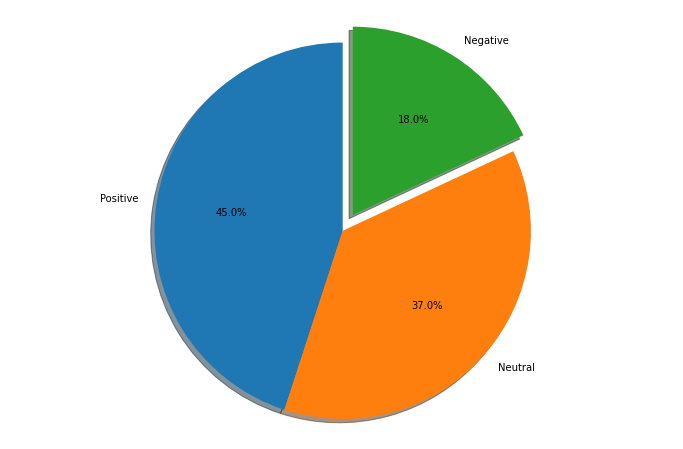

In [21]:
pichart = count_values_in_column(data,"sentiment")
names= pc.index
size = pc ["Percentage"]

labels = 'Positive', 'Neutral', 'Negative'

explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [30]:
data['label'] = 0
data.loc[data['compound'] > 0.10, 'label'] = 1
data.loc[data['compound'] < -0.10, 'label'] = -1
data

,Date,Time,user_id,location,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,label
0,2021-02-11,19:03:21,b'BurtonKelso',b'Greater Kansas City Area',b that time i met from he didn xe2 x...,0.0,0.000000,neutral,0.000,1.000,0.000,0.0000,0
1,2021-02-11,19:02:38,b'AnaraPublishing',"b'Leicester, England'",b with platforms like netflix and amazonprim...,0.0,0.125000,positive,0.105,0.786,0.109,0.0256,0
2,2021-02-11,19:01:05,b'WiltsColl',"b'Wiltshire, UK'",b this time last week we were still buzzing f...,0.2,0.483333,positive,0.000,0.854,0.146,0.5574,1
3,2021-02-11,19:00:41,b'poem1985',b'United Kingdom',b had a gorgeous tea amp now gonna chill wit...,0.7,0.900000,positive,0.000,0.733,0.267,0.6124,1
4,2021-02-11,19:00:32,b'screenkingsPH',b'Philippines',b newsoftheworld now streaming on netflix e...,-0.5,1.000000,negative,0.218,0.782,0.000,-0.6486,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,2021-02-09,12:56:36,b'AmandaSmith995',b'',b watch in hd now nfollow the link and enjo...,0.4,0.500000,positive,0.000,0.738,0.262,0.4939,1
3995,2021-02-09,12:55:19,b'netflixjunkieof',b'California',b xe2 x80 x98behind her eyes xe2 x80 x99 netf...,0.0,0.000000,neutral,0.000,1.000,0.000,0.0000,0
3996,2021-02-09,12:53:33,b'GalaxyGirl2002',"b'Northern Ireland, United Kingd'",b everyone is ways talking about the friends s...,0.5,0.600000,positive,0.000,0.826,0.174,0.5647,1
3997,2021-02-09,12:49:06,b'Tony_Rosie_',b'Planet Namek',b who xe2 x80 x99s watched the superb callmya...,1.0,1.000000,positive,0.000,0.687,0.313,0.6249,1


In [35]:
data = data.loc[data['label'] != 0]

In [36]:
pc = count_values_in_column(data,"label")
pc

,Total,Percentage
1,1733,71.55
-1,689,28.45


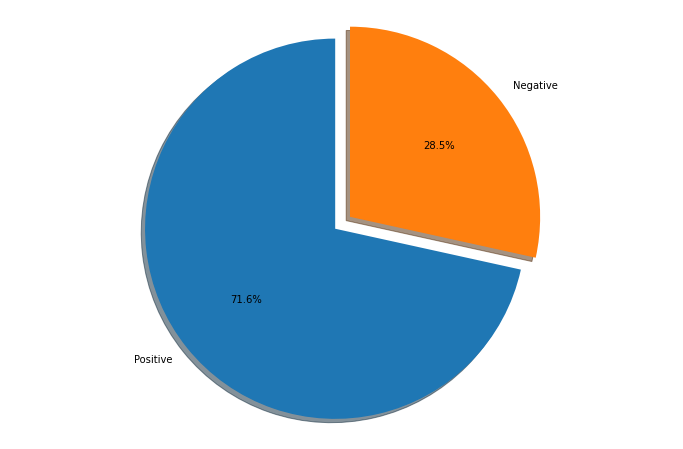

In [37]:
pichart = count_values_in_column(data,"label")
names= pc.index
size = pc ["Percentage"]

labels = 'Positive', 'Negative'

explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [38]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=3000,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


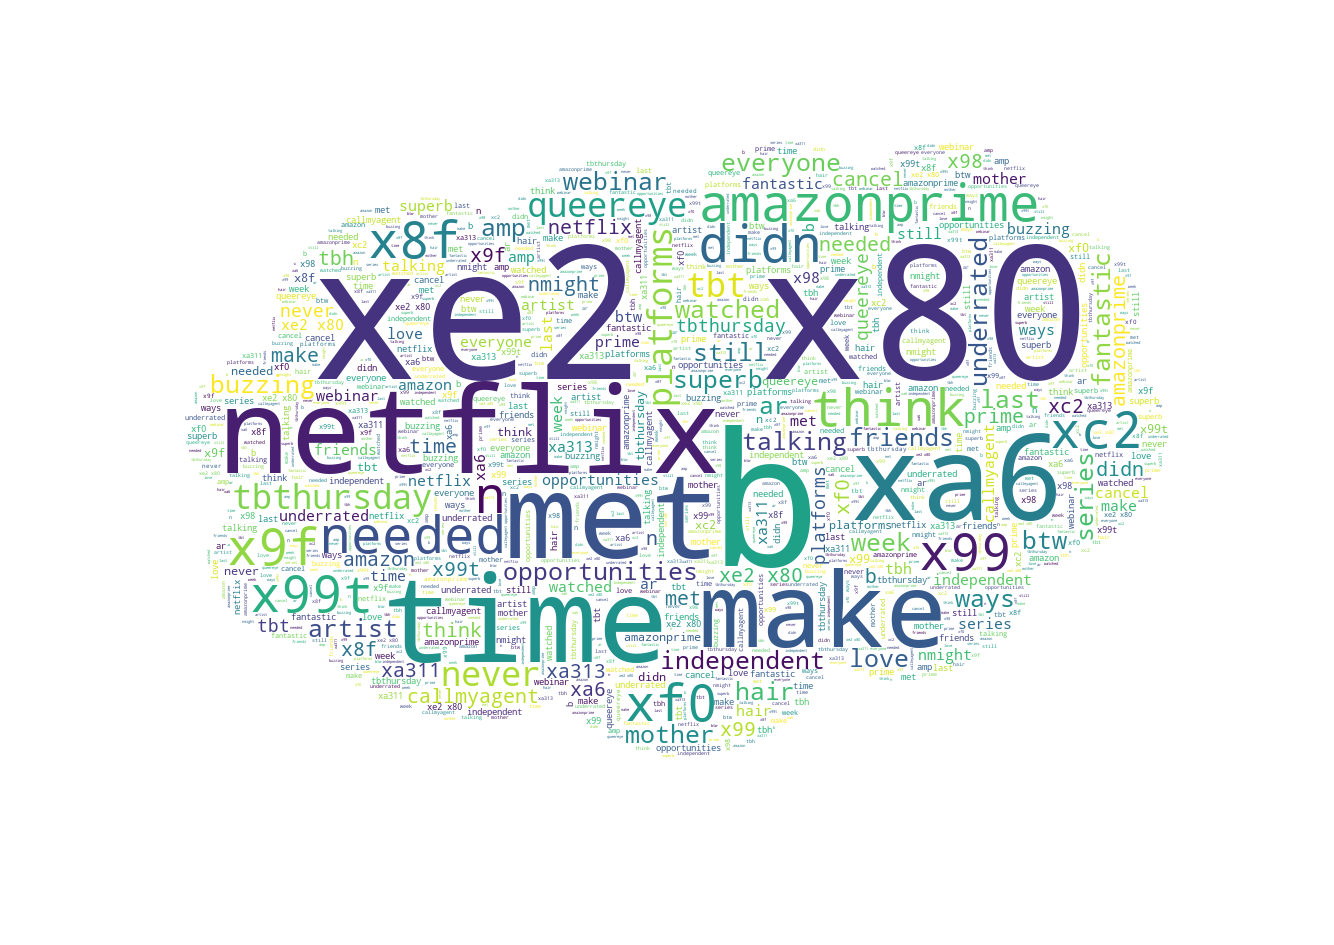

In [18]:
#Creating wordcloud for all tweets
create_wordcloud(data["text"].values)

Word Cloud Saved Successfully


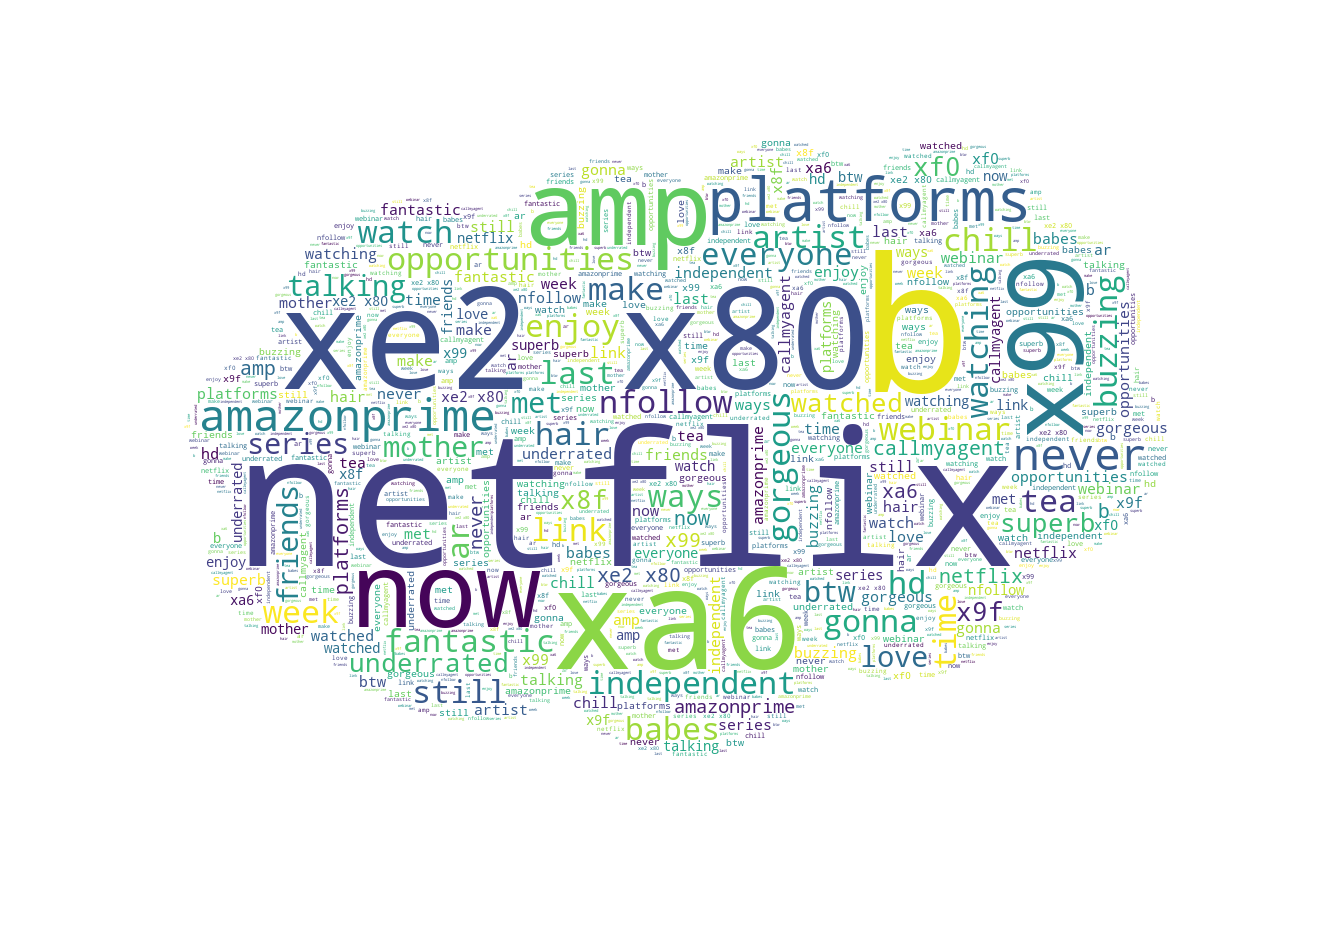

In [39]:
#Creating wordcloud for all positive tweets
create_wordcloud(data_positive["text"].values)

Word Cloud Saved Successfully


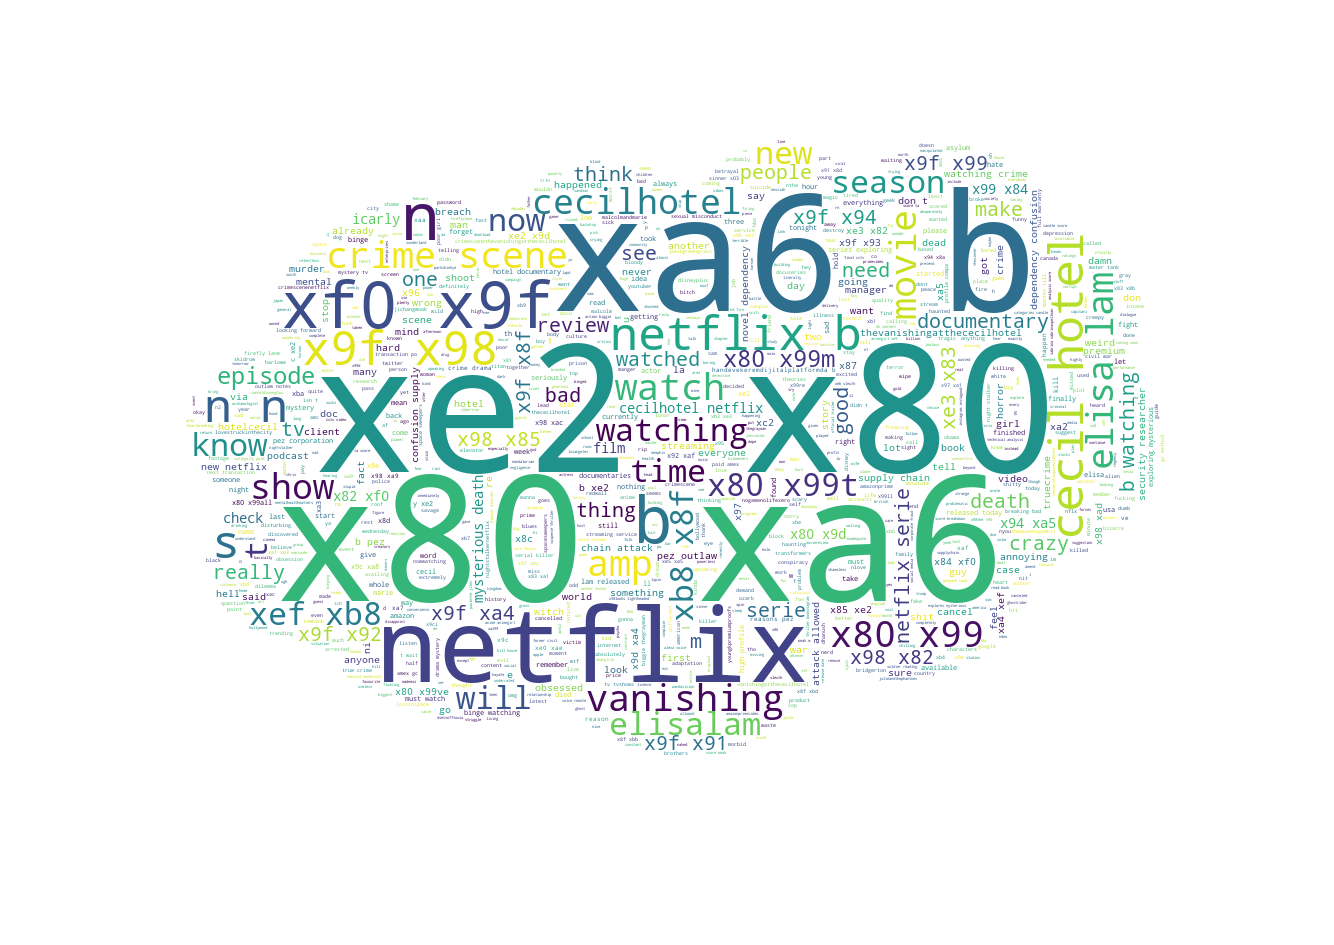

In [21]:
#Creating wordcloud for all negative tweets
create_wordcloud(data_negative["text"].values)

Word Cloud Saved Successfully


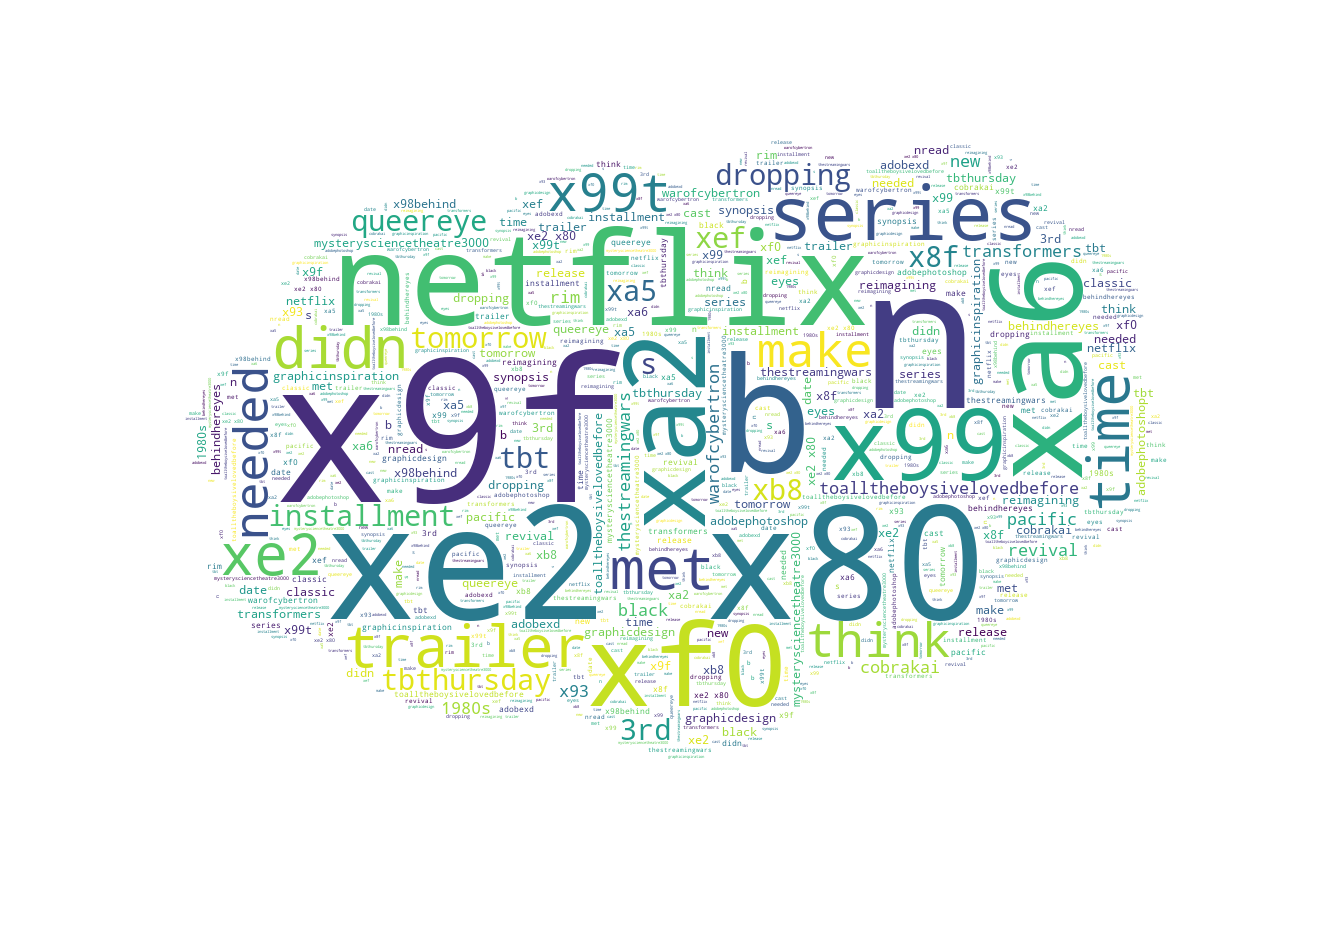

In [22]:
#Creating wordcloud for all neutral tweets
create_wordcloud(data_neutral["text"].values)

## Calculate the Ratio for the sentiment change

In [42]:
ratio = data.pos / (data.neg + data.pos)

In [43]:
ratio.head()

2    1.000000
3    1.000000
4    0.000000
7    1.000000
8    0.323432
dtype: float64

In [44]:
data['ratio'] = ratio
data

<ipython-input-44-07cec09c407d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratio'] = ratio


,Date,Time,user_id,location,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,label,ratio
2,2021-02-11,19:01:05,b'WiltsColl',"b'Wiltshire, UK'",b this time last week we were still buzzing f...,0.200000,0.483333,positive,0.000,0.854,0.146,0.5574,1,1.000000
3,2021-02-11,19:00:41,b'poem1985',b'United Kingdom',b had a gorgeous tea amp now gonna chill wit...,0.700000,0.900000,positive,0.000,0.733,0.267,0.6124,1,1.000000
4,2021-02-11,19:00:32,b'screenkingsPH',b'Philippines',b newsoftheworld now streaming on netflix e...,-0.500000,1.000000,negative,0.218,0.782,0.000,-0.6486,-1,0.000000
7,2021-02-11,18:59:13,b'thenerdstash',b'Nerds Incorporated',b iron fist finn jones reveals plot details f...,0.000000,0.000000,positive,0.000,0.797,0.203,0.4215,1,1.000000
8,2021-02-11,18:57:59,b'migealdude2',b'Mars',b malcolmandmarie falls victim to its over d...,-0.225000,0.600000,negative,0.205,0.698,0.098,-0.3182,-1,0.323432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,2021-02-09,12:58:54,b'uncle_fabs',b'',b my 2 cents peloton is the next netflix n...,0.045455,0.151515,positive,0.000,0.928,0.072,0.1779,1,1.000000
3992,2021-02-09,12:58:09,b'BoneNyou918',b'ChokeLahoma',b on theyready on netflix nis too funny,0.250000,1.000000,positive,0.000,0.674,0.326,0.4404,1,1.000000
3994,2021-02-09,12:56:36,b'AmandaSmith995',b'',b watch in hd now nfollow the link and enjo...,0.400000,0.500000,positive,0.000,0.738,0.262,0.4939,1,1.000000
3996,2021-02-09,12:53:33,b'GalaxyGirl2002',"b'Northern Ireland, United Kingd'",b everyone is ways talking about the friends s...,0.500000,0.600000,positive,0.000,0.826,0.174,0.5647,1,1.000000


Now let's concat our two data 

In [44]:
#df_new = pd.merge(data, df)
#df_new.head(5)

,Date,Time,user_id,location,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,ratio


In [35]:
df_new.describe()

,ratio
count,2440.000000
mean,0.702882
std,0.406809
min,0.000000
25%,0.426487
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
import matplotlib as plt 
df.sort_values(by='Time', inplace=True)
df.index = pd.to_datetime(df['Time'])
df['mean'] = df['compound'].expanding().mean()
df['rolling'] = df['compound'].rolling('6h').mean()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [ ]:
# plotting the points 
plt.plot(x = , y, color='green', linestyle='dashed', linewidth = 3, 
marker='o', markerfacecolor='blue', markersize=12) 

# setting x and y axis range 
plt.ylim(1,8) 
plt.xlim(1,8) 

# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 

# giving a title to my graph 
plt.title('Some cool customizations!') 

# function to show the plot 
plt.show() 
